# This notebook train the Neural Network model using 3 building blocks' morgan fingerprints as features

In [1]:
import numpy as np
import os, random, time
import pandas as pd
from pathlib import Path

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [3]:
def get_files(input_list):
    out_list=[]
    if type(input_list)==type(None):
        return out_list
    for item in input_list:
        
        if os.path.isdir(item):
            out_list.extend(list(Path(item).rglob("*.npz")))

        elif item[-4:]=='.npz':
            out_list.append(item)        
    
    random.seed(0)
    random.shuffle(out_list)
    return out_list

def read_from_file(file_name):
    data=np.load(file_name)
    return data['morgan1'],data['morgan2'],data['morgan3'], data['protein'], data['labels']

def read_from_test_file(file_name):
    data=np.load(file_name)
    return data['morgan1'],data['morgan2'],data['morgan3'], data['protein'], data['ids']

def generate_batches(files, batch_size=1024):
    counter = 0
    
    print_freq=max(1, len(files)//10)
    
    while counter<len(files):
        file_name = files[counter]

        counter +=1
        
        data=read_from_file(file_name)

        morgan1, morgan2, morgan3, protein, labels=data
        batch_size=max(batch_size,1)
        for local_index in range(0, labels.shape[0], batch_size):
            batch_morgan1=morgan1[local_index:(local_index + batch_size)]
            batch_morgan2=morgan2[local_index:(local_index + batch_size)]
            batch_morgan3=morgan3[local_index:(local_index + batch_size)]
            batch_protein=protein[local_index:(local_index + batch_size)]
            batch_labels=labels[local_index:(local_index + batch_size)]          

            yield batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_labels
        
        if counter%print_freq==0:
            print('.', end='',flush=True)

def generate_test_batches(files, batch_size=1024):
    counter = 0
    
    print_freq=max(1, len(files)//10)
    
    while counter<len(files):
        file_name = files[counter]

        counter +=1
        
        data=read_from_test_file(file_name)

        morgan1, morgan2, morgan3, protein, ids=data
        batch_size=max(batch_size,1)
        for local_index in range(0, ids.shape[0], batch_size):
            batch_morgan1=morgan1[local_index:(local_index + batch_size)]
            batch_morgan2=morgan2[local_index:(local_index + batch_size)]
            batch_morgan3=morgan3[local_index:(local_index + batch_size)]
            batch_protein=protein[local_index:(local_index + batch_size)]
            batch_ids=ids[local_index:(local_index + batch_size)]   

            yield batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_ids
        
        if counter%print_freq==0:
            print('.', end='',flush=True)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim, Tensor
from torch.nn.parallel import DataParallel

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(3075,2048)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2=nn.Linear(2048,1024)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4=nn.Linear(1024,512)
        self.fc5=nn.Linear(512,128)
        self.out=nn.Linear(128,1)
        
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc4(x))
        x=F.relu(self.fc5(x))
        out=self.out(x)
        return out

In [6]:
dev = 'cuda' #if torch.cuda.is_available() else 'cpu'

net = Net().to(dev)
net = DataParallel(net)  # Wrap the model with DataParallel

optimizer = optim.Adam(net.parameters(), lr=0.001)


In [7]:
model_details=str(net.to(torch.device(dev)))
print(model_details)
num_params=sum(p.numel() for p in net.parameters())
print('# Parameters=', num_params)

DataParallel(
  (module): Net(
    (fc1): Linear(in_features=3075, out_features=2048, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout3): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=1024, out_features=512, bias=True)
    (fc5): Linear(in_features=512, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)
# Parameters= 8988417


In [8]:
train_files=get_files(['morgan_train_complete/'])
test_files=get_files(['morgan_validation_complete/'])

In [9]:
print('num of train_file: ',len(train_files))
print('num of validation_file: ',len(test_files))

num of train_file:  473
num of validation_file:  119


In [10]:
pos_weight=torch.Tensor(np.array(5.0))
pos_weight_vali=torch.Tensor(np.array(1.0))
epoch_num=20
model_save_dir = "/mnt/isilon/wang_lab/shared/Belka/analysis/saved_models/"
loss_log=[]

# Training loop
for i in range(epoch_num):
    t=time.time()
    
    net.train()
    train_loss = 0
    train_len = 0
    train_generator = generate_batches(train_files, batch_size=4096)
    for batch in train_generator:
        optimizer.zero_grad()
        batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_labels = batch
        batch_morgan = np.concatenate((batch_morgan1, batch_morgan2, batch_morgan3, batch_protein), 1)
        score = net(torch.Tensor(batch_morgan).to(dev))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(score, torch.Tensor(batch_labels)[:, None].to(dev), pos_weight=pos_weight)
        train_loss += loss.cpu().item() * len(score)
        train_len += len(score)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        net.eval()
        preds = []
        labels = []
        test_loss = 0
        test_generator = generate_batches(test_files, batch_size=500000)
        for batch in test_generator:
            batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_labels = batch
            batch_morgan = np.concatenate((batch_morgan1, batch_morgan2, batch_morgan3, batch_protein), 1)
            score = net(torch.Tensor(batch_morgan).to(dev))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(score, torch.Tensor(batch_labels)[:, None].to(dev), pos_weight=pos_weight_vali)
            preds.append(torch.sigmoid(score).cpu().numpy())
            labels.append(batch_labels)
            test_loss += loss.cpu().item() * len(score)

        preds = np.vstack(preds)[:, 0]
        labels = np.hstack(labels)

        # Calculate additional metrics
        ap = average_precision_score(labels, preds)
        precision = precision_score(labels, preds > 0.5)
        recall = recall_score(labels, preds > 0.5)
        f1 = f1_score(labels, preds > 0.5)
        roc_auc = roc_auc_score(labels, preds)

        print(f'\nEpoch={i+1} Train_Loss={train_loss/train_len:.6f} Test_Loss={test_loss/len(labels):.6f} '
              f'Test AP={ap:.6f} Precision={precision:.6f} Recall={recall:.6f} F1={f1:.6f} ROC_AUC={roc_auc:.6f} Epoch_time={time.time()-t:.6f}')
        
        #save the loss_log for plotting
        loss_log.append((i+1,train_loss/train_len, test_loss/len(labels)))
        #save the model at each epoch
        torch.save({
            'epoch': i+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, model_save_dir+f'bldblock_NN_epoch_{i+1}.pth')

/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/torch/nn/modules/linear.py:116: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


....................
Epoch=1 Train_Loss=0.047012 Test_Loss=0.020294 Test AP=0.369800 Precision=0.413575 Recall=0.379875 F1=0.396009 ROC_AUC=0.971152 Epoch_time=5270.803085
....................
Epoch=2 Train_Loss=0.037697 Test_Loss=0.018513 Test AP=0.484087 Precision=0.470083 Recall=0.536224 F1=0.500980 ROC_AUC=0.979995 Epoch_time=5361.050854
....................
Epoch=3 Train_Loss=0.035667 Test_Loss=0.018200 Test AP=0.544380 Precision=0.466381 Recall=0.618722 F1=0.531858 ROC_AUC=0.983040 Epoch_time=5495.985816
....................
Epoch=4 Train_Loss=0.034694 Test_Loss=0.018125 Test AP=0.565835 Precision=0.469058 Recall=0.642698 F1=0.542318 ROC_AUC=0.984340 Epoch_time=5428.812696
....................
Epoch=5 Train_Loss=0.034075 Test_Loss=0.018452 Test AP=0.605128 Precision=0.450483 Recall=0.690152 F1=0.545138 ROC_AUC=0.985475 Epoch_time=5412.650311
....................
Epoch=6 Train_Loss=0.033545 Test_Loss=0.018352 Test AP=0.626330 Precision=0.460824 Recall=0.695730 F1=0.554421 ROC_AUC=

<Axes: >

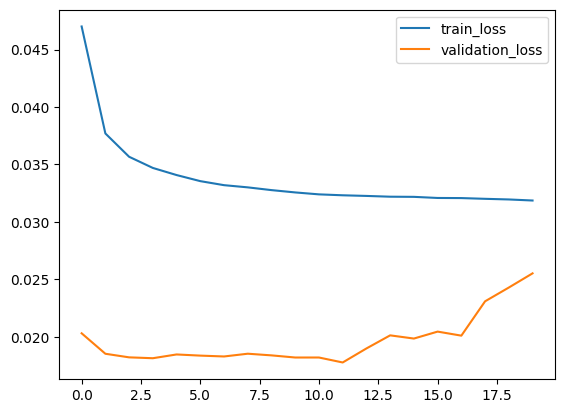

In [11]:

loss_df = pd.DataFrame(loss_log,columns=['epoch', 'train_loss', 'validation_loss'])
loss_df[['train_loss', 'validation_loss']].plot()

In [12]:
loss_df.to_csv('bldblock_NN_epoch_1-20.csv',index=False)

Model Parameters = 23613441

num of train_file:  5
num of validation_file:  1
batch_size=100000000: 24.4 s
batch size 10000000: 24.7 s
batch size 1000000: 24.6 s
batch_size=100000: 23.4 s
batch size 1024: 37.5 s

num of train_file:  20
num of validation_file:  4
batch_size=100000000: 1min 37s
batch size 10000000: 1min 42s
batch size 1024: 4min 2s

## test on the real competition test data

In [14]:
model_load_path = "/mnt/isilon/wang_lab/shared/Belka/analysis/saved_models/bldblock_NN_epoch_17.pth"
checkpoint = torch.load(model_load_path)

# load the model and continue training
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(dev)
net = DataParallel(net) #do this because previous model is within DataParallel
net.load_state_dict(checkpoint['model_state_dict'])


optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = loss.load_state_dict(checkpoint['loss'])

In [19]:
test_files=get_files(['morgan_test_complete/'])

In [20]:
test_files

[PosixPath('morgan_test_complete/data_test1.npz'),
 PosixPath('morgan_test_complete/data_test2.npz'),
 PosixPath('morgan_test_complete/data_test0.npz'),
 PosixPath('morgan_test_complete/data_test3.npz')]

In [22]:
with torch.no_grad():
    net.eval()
    preds = []
    ids = []
    
    
    test_generator = generate_test_batches(test_files, batch_size=500000)
    for batch in test_generator:
        batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_ids = batch
        batch_morgan = np.concatenate((batch_morgan1, batch_morgan2, batch_morgan3, batch_protein), 1)
        score = net(torch.Tensor(batch_morgan).to(dev))
        preds.append(torch.sigmoid(score).cpu().numpy())
        ids.append(batch_ids)

    preds = np.vstack(preds)[:, 0]
    ids = np.vstack(ids)[:,0]
    print("\n prediction on text dataset finished.")

df = pd.DataFrame({
    'id': ids,
    'preds': preds
})

.... prediction on text dataset finished.


In [23]:
df.to_csv('/mnt/isilon/wang_lab/shared/Belka/analysis/bldblock_NN_epoch_17_submission.csv',index=None)

In [47]:
#this is the original trainning part, keep it for reference

%%time
pos_weight=torch.Tensor(np.array(5.0))
epoch_num=10

for i in range(epoch_num):
    net.train()
    train_loss=0
    train_generator=generate_batches(train_files, batch_size=1024)
    for batch in train_generator:
        optimizer.zero_grad()
        batch_morgan, batch_protein, batch_labels=batch
        batch_morgan=np.concatenate((batch_morgan, batch_protein),1) #combine morgan fp with protein onehot encoding
        score=net(torch.Tensor(batch_morgan).to(dev))
        loss =  torch.nn.functional.binary_cross_entropy_with_logits(score, torch.Tensor(batch_labels)[:,None].to(dev), pos_weight=pos_weight)
        train_loss+=loss.cpu().item()*len(score)
        loss.backward()
        optimizer.step()
    
    
    with torch.no_grad():
        net.eval()
        preds=[]
        labels=[]
        test_loss=0
        test_generator=generate_batches(test_files, batch_size=1024)
        for batch in test_generator:
            batch_morgan, batch_protein, batch_labels=batch
            batch_morgan=np.concatenate((batch_morgan, batch_protein),1)
            score=net(torch.Tensor(batch_morgan).to(dev))
            loss =  torch.nn.functional.binary_cross_entropy_with_logits(score, torch.Tensor(batch_labels)[:,None].to(dev), pos_weight=pos_weight)
            preds.append(torch.nn.functional.sigmoid(score))
            labels.append(batch_labels)
            test_loss+=loss.cpu().item()*len(score)
            
        preds=torch.vstack(preds).cpu().numpy()[:,0]
        labels=np.hstack(labels)
        ap=average_precision_score(labels, preds)
        print('\n Epoch={} Train_Loss={} Test_Loss={} Test AP={}'.format(i+1, train_loss/len(labels), test_loss/len(labels), ap))

...............
 Epoch=1 Train_Loss=1.003138149199302 Test_Loss=0.04882204769590944 Test AP=0.13260512288866608
...............
 Epoch=2 Train_Loss=0.8343921044622662 Test_Loss=0.052541076241587104 Test AP=0.15806395912532023
...............
 Epoch=3 Train_Loss=0.7964697278223664 Test_Loss=0.06023136017497704 Test AP=0.16564010288688769
...............
 Epoch=4 Train_Loss=0.7719787498841771 Test_Loss=0.06954713337385077 Test AP=0.16598595814173905
...............
 Epoch=5 Train_Loss=0.7594206354114563 Test_Loss=0.11244394741869336 Test AP=0.17529272770581467
...............
 Epoch=6 Train_Loss=0.7488237145274264 Test_Loss=0.156620718493725 Test AP=0.1808955108795634
...............
 Epoch=7 Train_Loss=0.7353306274759498 Test_Loss=0.32474393346613667 Test AP=0.17521899748532252
...............
 Epoch=8 Train_Loss=0.7311725073708566 Test_Loss=0.4824021732787721 Test AP=0.18973572540806538
...............
 Epoch=9 Train_Loss=0.7230835853912253 Test_Loss=0.5686870524970539 Test AP=0.196638